In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
import copy
import os

Note that I unzip all archives in local directories, be careful with that.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

#### Data preprocessing

In [2]:
data = pd.read_csv('Task 1.csv')
data.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


We have quite small dataset.

In [3]:
data.shape

(1000, 8)

It seems that our dataset has no null values.

In [4]:
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Let's check unique values in each of the columns.

In [5]:
data['lunch'].unique()

array(['standard', 'free/reduced'], dtype=object)

In [6]:
data['race/ethnicity'].unique()

array(['group A', 'group D', 'group E', 'group B', 'group C'],
      dtype=object)

In [7]:
data['parental level of education'].unique()

array(['high school', 'some high school', 'some college',
       "associate's degree", "bachelor's degree", "master's degree"],
      dtype=object)

In [8]:
data['test preparation course'].unique()

array(['completed', 'none'], dtype=object)

##### Data encoding

In [9]:
def one_hot_encoding(data, column):
    new_data = data.copy()
    new_data = pd.get_dummies(new_data, columns=[column], prefix=column)
    return new_data

In [10]:
from sklearn.preprocessing import OrdinalEncoder

def ordinal_encoding(data, column):
    new_data = data.copy()
    encoder = OrdinalEncoder()
    data_col = np.array(new_data[column])
    data_col = np.reshape(data_col, (len(data_col),1))
    new_data[column] = encoder.fit_transform(data_col)
    return new_data

In [11]:
def my_ordinal_encoding(data, column, dictionary):
  new_data = data.copy()
  new_data[column] = [dictionary.get(element) for element in new_data[column]]
  return new_data

In [12]:
data = data.rename(columns={'gender':"gender", 'race/ethnicity':"race", 'parental level of education':"p_education", 'lunch':"lunch", 'test preparation course':"cource", 'math score':"m_score", 'reading score':"r_score", 'writing score':"w_score"})

In [13]:
df1 = my_ordinal_encoding(data=data, column='lunch', dictionary={'standard': 1, 'free/reduced':0})
df1 = my_ordinal_encoding(data=df1, column='cource', dictionary={'completed': 1, 'none':0})
df1 = my_ordinal_encoding(data=df1, column='p_education', dictionary={'some high school': 0, 'high school':1, 'some college':2, "associate's degree": 3, "bachelor's degree": 4, "master's degree": 5})
df1

,gender,race,p_education,lunch,cource,m_score,r_score,w_score
0,male,group A,1,1,1,67,67,63
1,female,group D,0,0,0,40,59,55
2,male,group E,2,0,0,59,60,50
3,male,group B,1,1,0,77,78,68
4,male,group E,3,1,1,78,73,68
...,...,...,...,...,...,...,...,...
995,male,group C,1,1,0,73,70,65
996,male,group D,3,0,1,85,91,92
997,female,group C,0,0,0,32,35,41
998,female,group C,2,1,0,73,74,82


In [14]:
df = one_hot_encoding(data=data, column='race')
df = one_hot_encoding(data=df, column='gender')
df = my_ordinal_encoding(data=df, column='lunch', dictionary={'standard': 1, 'free/reduced':0})
df = my_ordinal_encoding(data=df, column='cource', dictionary={'completed': 1, 'none':0})
df = my_ordinal_encoding(data=df, column='p_education', dictionary={'some high school': 0, 'high school':1, 'some college':2, "associate's degree": 3, "bachelor's degree": 4, "master's degree": 5})
df

,p_education,lunch,cource,m_score,r_score,w_score,race_group A,race_group B,race_group C,race_group D,race_group E,gender_female,gender_male
0,1,1,1,67,67,63,1,0,0,0,0,0,1
1,0,0,0,40,59,55,0,0,0,1,0,1,0
2,2,0,0,59,60,50,0,0,0,0,1,0,1
3,1,1,0,77,78,68,0,1,0,0,0,0,1
4,3,1,1,78,73,68,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,0,73,70,65,0,0,1,0,0,0,1
996,3,0,1,85,91,92,0,0,0,1,0,0,1
997,0,0,0,32,35,41,0,0,1,0,0,1,0
998,2,1,0,73,74,82,0,0,1,0,0,1,0


In [15]:
df

,p_education,lunch,cource,m_score,r_score,w_score,race_group A,race_group B,race_group C,race_group D,race_group E,gender_female,gender_male
0,1,1,1,67,67,63,1,0,0,0,0,0,1
1,0,0,0,40,59,55,0,0,0,1,0,1,0
2,2,0,0,59,60,50,0,0,0,0,1,0,1
3,1,1,0,77,78,68,0,1,0,0,0,0,1
4,3,1,1,78,73,68,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,0,73,70,65,0,0,1,0,0,0,1
996,3,0,1,85,91,92,0,0,0,1,0,0,1
997,0,0,0,32,35,41,0,0,1,0,0,1,0
998,2,1,0,73,74,82,0,0,1,0,0,1,0


In [16]:
target = df[['m_score','r_score','w_score']]
features = df[['lunch', 'cource', 'p_education', 'race_group A', 'race_group B', 'race_group C', 'race_group D', 'race_group E', 'gender_male', 'gender_female']]

In [17]:
target

,m_score,r_score,w_score
0,67,67,63
1,40,59,55
2,59,60,50
3,77,78,68
4,78,73,68
...,...,...,...
995,73,70,65
996,85,91,92
997,32,35,41
998,73,74,82


##### Data split

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state=0)

In [19]:
X_train

,lunch,cource,p_education,race_group A,race_group B,race_group C,race_group D,race_group E,gender_male,gender_female
687,1,1,3,0,0,0,1,0,1,0
500,0,0,1,0,1,0,0,0,0,1
332,1,0,2,0,0,1,0,0,1,0
979,0,1,4,0,1,0,0,0,0,1
817,1,0,5,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
835,1,0,0,0,1,0,0,0,0,1
192,0,0,0,0,0,0,0,1,1,0
629,1,0,1,0,0,1,0,0,1,0
559,0,0,1,0,0,0,0,1,1,0


In [20]:
log_interval = 10

In [21]:
train_batch_size = 40
test_batch_size = 10


train_target = torch.tensor(Y_train.values.astype(np.float32))
train_features = torch.tensor(X_train.values.astype(np.float32))

test_target = torch.tensor(Y_test.values.astype(np.float32))
test_features = torch.tensor(X_test.values.astype(np.float32))

train_dataset = data_utils.TensorDataset(train_features, train_target)
test_dataset = data_utils.TensorDataset(test_features, test_target)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

##### ANN

In [22]:
class Net_2layers(nn.Module):
    def __init__(self):
        super(Net_2layers, self).__init__() 
        self.hidden1 = nn.Linear(10, 30)
        self.output = nn.Linear(30, 3) 


    def forward(self, x):
        x = x.view(-1, 10)
        x = F.relu(self.hidden1(x))
        x = self.output(x)
        return x

In [23]:
class Net_1layer(nn.Module):
    def __init__(self):
        super(Net_1layer, self).__init__() 
        self.output = nn.Linear(10, 3) 


    def forward(self, x):
        x = x.view(-1, 10)
        x = self.output(x)
        return x

In [24]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(use_cuda)
print(torch.version.cuda)

True
11.6


In [25]:
def initialise_model(network):
    model = network().to(device)
    return model

In [26]:
model_1layer = initialise_model(Net_1layer)
model_2layers = initialise_model(Net_2layers)
print(model_1layer)
print(model_2layers)

Net_1layer(
  (output): Linear(in_features=10, out_features=3, bias=True)
)
Net_2layers(
  (hidden1): Linear(in_features=10, out_features=30, bias=True)
  (output): Linear(in_features=30, out_features=3, bias=True)
)


##### Common functions

Note that code for train and test functions was taken from labs

In [27]:
def train(model, device, train_loader, criterion, optimizer, epoch, show_results=True):
    model.train()
    start_time = time()
    epoch_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(target)
        if show_results:
            if batch_idx % log_interval == 0:
                print(f'\rTrain Epoch {epoch}:',
                    f'[{batch_idx * len(data)}/{len(train_loader.dataset)}',
                    f'({100. * batch_idx / len(train_loader):.0f}%)]',
                    f'\tLoss: {loss.item():.6f}',
                    end='')

    if show_results:
        print(f'\rTrain Epoch: {epoch} Average Loss: {epoch_loss/(len(train_loader.dataset)):.6f}, elapsed time:{time()-start_time:.2f}s')

In [28]:
def test(model, device, test_loader, criterion, show_results=True):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * len(target)

    test_loss /= len(test_loader.dataset)

    if show_results:
        print('\rTest set: Average loss: {:.4f}'.format(test_loss))
    return test_loss

In [29]:
def evaluate(model, epochs=30, lr=0.1, momentum= 0.5, criterion = nn.MSELoss(), show_results=True, early_stopping=True):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    min_test_loss = float('inf')
    min_test_length = 0
    min_test_limit = 3
    min_epoch = -1


    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, epoch, show_results)
        val = test(model, device, test_loader, criterion, show_results)
        if val < min_test_loss:
            min_epoch = epoch
            min_test_loss = val
            min_test_length = 0
        else:
            min_test_length += 1

        if early_stopping:
            if min_test_length >= min_test_limit or epoch==epochs:
                if show_results:
                    print("Best model was at epoch ", min_epoch, " with value ", min_test_loss)
                break
        else:
            if epoch == epochs:
                if show_results:
                    print("Best model was at epoch ", min_epoch, " with value ", min_test_loss)
            
    return min_test_loss

##### Evaluation of models

I'd be using lr=0.1 and momentum=0.5 as default parameters. Since I found them the best during tuning.

Firstly. let's check simple model with 2 layers:

In [30]:
evaluate(model_2layers)

Train Epoch: 1 Average Loss: 571054.568854, elapsed time:4.11s
Test set: Average loss: 2741.5605
Train Epoch: 2 Average Loss: 662.654844, elapsed time:0.03s
Test set: Average loss: 207.6096
Train Epoch: 3 Average Loss: 240.221552, elapsed time:0.03s
Test set: Average loss: 204.9908
Train Epoch: 4 Average Loss: 239.417821, elapsed time:0.04s
Test set: Average loss: 205.6241
Train Epoch: 5 Average Loss: 239.737597, elapsed time:0.04s
Test set: Average loss: 205.0680
Train Epoch: 6 Average Loss: 239.599342, elapsed time:0.05s
Test set: Average loss: 205.2364
Best model was at epoch  3  with value  204.99075775146486


204.99075775146486

We recieved quite good MSE score. Now let's check model with 1 layer:


In [31]:
evaluate(model= model_1layer)

Train Epoch: 1 Average Loss: 712.834050, elapsed time:0.03s
Test set: Average loss: 195.5582
Train Epoch: 2 Average Loss: 181.084452, elapsed time:0.03s
Test set: Average loss: 171.8586
Train Epoch: 3 Average Loss: 165.384901, elapsed time:0.03s
Test set: Average loss: 167.3319
Train Epoch: 4 Average Loss: 160.793607, elapsed time:0.04s
Test set: Average loss: 166.9042
Train Epoch: 5 Average Loss: 163.623971, elapsed time:0.02s
Test set: Average loss: 167.7090
Train Epoch: 6 Average Loss: 160.485663, elapsed time:0.03s
Test set: Average loss: 165.5395
Train Epoch: 7 Average Loss: 158.517248, elapsed time:0.03s
Test set: Average loss: 169.4117
Train Epoch: 8 Average Loss: 158.796450, elapsed time:0.02s
Test set: Average loss: 169.9977
Train Epoch: 9 Average Loss: 158.391201, elapsed time:0.03s
Test set: Average loss: 171.2611
Best model was at epoch  6  with value  165.53946228027343


165.53946228027343

We achived better results, but that's not all, let's check output of our ,pdel on some data from test dataset:

In [32]:
X_test.iloc[:3,:]

,lunch,cource,p_education,race_group A,race_group B,race_group C,race_group D,race_group E,gender_male,gender_female
993,1,0,3,1,0,0,0,0,0,1
859,1,1,1,0,0,0,1,0,0,1
298,1,0,1,0,1,0,0,0,1,0


In [33]:
Y_test.iloc[:3,:]

,m_score,r_score,w_score
993,58,54,58
859,74,84,79
298,69,58,50


In [34]:
some_data = np.array(X_test.iloc[:3,:])
some_data_tensor = torch.tensor(some_data)
some_data_tensor = some_data_tensor.float()

In [35]:
some_data_tensor=some_data_tensor.to(device)

In [36]:
model_1layer(some_data_tensor)

tensor([[69.3764, 75.3161, 73.7536],
        [73.3209, 82.3474, 84.9440],
        [68.1309, 62.9887, 58.8125]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [37]:
model_2layers(some_data_tensor)

tensor([[65.9721, 68.7239, 67.3274],
        [65.9721, 68.7239, 67.3274],
        [65.9721, 68.7239, 67.3274]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Looks kinda bad. It seems that model with 2 layers tends to find mean value for target columns in order to minimize MSE. Since performance of our model with 1 layer is better overall, let's use it and tune some hyperparameters.

In [38]:
lr_grid = [0.2, 0.1, 0.05, 0.01]
momentum_grid = [0.5, 0.3, 0.1]
best_lr = -1
best_momentum = -1
min_loss = float('inf')
for lr in lr_grid:
    for momentum in momentum_grid:
        model_1layer = initialise_model(Net_1layer)
        temp_loss = evaluate(model_1layer, lr=lr, momentum=momentum, show_results=False)
        print(f"Learning rate = {lr}, Momentum = {momentum}, Minimal Average Loss = {temp_loss}")
        if temp_loss < min_loss:
            best_lr = lr
            best_momentum = momentum
            min_loss = temp_loss
print(min_loss, best_lr, best_momentum)

Learning rate = 0.2, Momentum = 0.5, Minimal Average Loss = 165.8880126953125
Learning rate = 0.2, Momentum = 0.3, Minimal Average Loss = 166.36996841430664
Learning rate = 0.2, Momentum = 0.1, Minimal Average Loss = 166.54618797302246
Learning rate = 0.1, Momentum = 0.5, Minimal Average Loss = 165.59480972290038
Learning rate = 0.1, Momentum = 0.3, Minimal Average Loss = 168.84259223937988
Learning rate = 0.1, Momentum = 0.1, Minimal Average Loss = 165.6169776916504
Learning rate = 0.05, Momentum = 0.5, Minimal Average Loss = 165.63813667297364
Learning rate = 0.05, Momentum = 0.3, Minimal Average Loss = 166.11150779724122
Learning rate = 0.05, Momentum = 0.1, Minimal Average Loss = 165.31357421875
Learning rate = 0.01, Momentum = 0.5, Minimal Average Loss = 168.60809783935548
Learning rate = 0.01, Momentum = 0.3, Minimal Average Loss = 171.83384323120117
Learning rate = 0.01, Momentum = 0.1, Minimal Average Loss = 175.9578483581543
165.31357421875 0.05 0.1


After running that code I found that lr=0.1 and momentum=0.5 are the best. However it might be subject to change dou to some random processes. Anyway difference in MSE almost negligible in that cases. I'd be using lr=0.1 and momentum=0.5 as default parameters.

### Questions
1. What preprocessing techniques did you use? Why?
    - I used data encoding in order to use categorical features. I decided to use one-hot encoding for race and gender, for other categorical features - ordinal encoding. Races and genders can't be put in some relation (f.e. race_1 id better than race_2 - it doesn't make any sense), at the same, it is possible to arrange level of education, since they are go one after another (i.e. "some high school" < "high school" < "some college" < "associate's degree" < "bachelor's degree" < "master's degree") , same situation is about taking cources and having a lunch.
2. Describe the fine-tuning process and how you reached your model architecture.
    - I tried to play with lr, momentum, number of layers and number of epoch, however I found the folowing propblem: model produses same results for any features input during each test process (f.e. I recieved [66.3383, 69.1515, 68.2810] as predicted values during test process in some epoch for every feature combination in test dataset). It seems to be that models with more that 1 layer tends to find average values for every target value, in order to lower loss function and it works if just look on MSE metric. However, when I tried to use just 1 layer (it's fair to say, that I just use linear regression model) I solved that problem and achieved quite good metric values. It shows that original data is linear, therefore one layer is enough. If there are a lot of data or there is nonlinear relation between features and targets, then more complex structure with several layers would perform better.

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

#### Data preparation
Uploading datasets in python and putting them in dataloaders.

In [39]:
TRAIN_BATCH_SIZE = 100
VAL_BATCH_SIZE = 500
TEST_BATCH_SIZE = 50

data_transformations = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
    ])

data_transformations_with_rotate = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
    ])

val_dataset = torchvision.datasets.ImageFolder(root='./triple_mnist/triple_mnist/val', transform=data_transformations)
test_dataset = torchvision.datasets.ImageFolder(root='./triple_mnist/triple_mnist/test', transform=data_transformations)

val_data_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True,  num_workers=10)
test_data_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True,  num_workers=10)

In [40]:
def recive_train_loader(augmentation=True, shuffle=True):
    if augmentation:
        train_dataset = torchvision.datasets.ImageFolder(root='./triple_mnist/triple_mnist/train', transform=data_transformations_with_rotate)
    else:
        train_dataset = torchvision.datasets.ImageFolder(root='./triple_mnist/triple_mnist/train', transform=data_transformations)
    train_data_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=shuffle,  num_workers=10)
    return train_data_loader

After reviewing the dataset I come up with an idea to split picture on 3 equal parts and use model to predict just 1 digit at a time (just classification of data from MNIST dataset). That helps to make model more simple (only predict 1 of 10 possible values).

#### Common functions

In [41]:
def train(model, device, train_loader, criterion, optimizer, epoch, show_results=True):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    parts = [(0,28,2),(28,56,1),(56,84,0)]

    for batch_idx, (Data, Target) in enumerate(train_loader):
        for (i,j,k) in parts:
            data_t = Data[:,:,:,i:j]
            target_t = Target.detach().clone()
            if k==0:
                target_t.apply_(lambda x: int(train_loader.dataset.classes[x])%10)
            elif k==1:
                target_t.apply_(lambda x: int(train_loader.dataset.classes[x])//10%10)
            else:
                target_t.apply_(lambda x: int(train_loader.dataset.classes[x])//100%10)

            data, target = data_t.to(device), target_t.to(device)
            optimizer.zero_grad()
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * len(target)

        if show_results:
            if batch_idx % log_interval == 0:
                print(f'\rTrain Epoch {epoch}:',
                    f'[{batch_idx * len(data)}/{len(train_loader.dataset)}',
                    f'({100. * batch_idx / len(train_loader):.0f}%)]',
                    f'\tLoss: {loss.item():.6f}',
                    end='')
                    
    acc = 100. * correct / (len(train_loader.dataset)*3)
    if show_results:
        print(f'\rTrain Epoch: {epoch} Average Loss: {epoch_loss/(len(train_loader.dataset)*3):.6f}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss/(len(train_loader.dataset)*3), acc

In [42]:
def test(model, device, test_loader, criterion, show_results=True):
    model.eval()
    test_loss = 0
    correct = 0
    parts = [(0,28,2),(28,56,1),(56,84,0)]
    with torch.no_grad():
        for Data, Target in test_loader:
            for (i,j,k) in parts:
                data_t = Data[:,:,:,i:j]
                target_t = Target.detach().clone()
                if k==0:
                    target_t.apply_(lambda x: int(test_loader.dataset.classes[x])%10)
                elif k==1:
                    target_t.apply_(lambda x: int(test_loader.dataset.classes[x])//10%10)
                else:
                    target_t.apply_(lambda x: int(test_loader.dataset.classes[x])//100%10)
                     
                data, target = data_t.to(device), target_t.to(device)
                output = model(data)
                test_loss += criterion(output, target).item() * len(target)  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
    
    acc = 100. * correct / (len(test_loader.dataset)*3)
    if show_results:
        print(f'\rTest set: Average loss: {test_loss/(len(test_loader.dataset)*3):.4f},',
            f'Accuracy: {correct}/{len(test_loader.dataset)*3}', 
            f'({acc:.0f}%)\n')
    
    return test_loss/(len(test_loader.dataset)*3), acc

In order to make models more robust training datasets would be influenced by one random augmentation technique (random rotate). So for each training epoch training data would be different.

In [43]:
def evaluate(model, epochs=3, lr = 0.1, momentum = 0.5, criterion = nn.CrossEntropyLoss()):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(1, epochs + 1):
        train_data_loader = recive_train_loader()
        train_loss, train_acc = train(model, device, train_data_loader, criterion, optimizer, epoch)

        test_loss, test_acc = test(model, device, test_data_loader, criterion)

        # deep copy the model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    # reload model with best performance
    model.load_state_dict(best_model_wts)


In [44]:
def validate(model, epochs=3, lr = 0.1, momentum = 0.5, criterion = nn.CrossEntropyLoss(), min_acc = 70, show_results = False):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    best_acc = 0.0
    min_loss = float("inf")


    for epoch in range(1, epochs + 1):
        train_data_loader = recive_train_loader()
        train_loss, train_acc = train(model, device, train_data_loader, criterion, optimizer, epoch, show_results)

        val_loss, val_acc = test(model, device, val_data_loader, criterion, show_results)

        if val_acc >= best_acc and val_loss < min_loss:
            best_acc = val_acc
            min_loss = val_loss

        # if model would have accuracy less than 70% we will drop it
        if val_acc < min_acc:
            return val_acc, val_loss, True

    return best_acc, min_loss, False

In [45]:
def get_results_to_compare(model):
    timer = time()
    some_model = initialise_model(model)
    temp_acc, temp_loss, early_stop = validate(some_model, show_results=False)
    print(f"Model = {model}, Minimal Average Loss = {temp_loss}, Accuracy = {temp_acc}, Time = {time()-timer}, Was interrupted = {early_stop}")

#### Model adaptation
Now model should perform classification task. Therefore I need not only to change input(picture size) and output(10 digits) parameters, but also add relu and change loss function.

In [46]:
class ANN_Model(nn.Module):
    def __init__(self):
        super(ANN_Model, self).__init__() 
        self.output = nn.Linear(84*28, 10) 

    def forward(self, x):
        x = x.view(-1, 84*28)
        x = self.output(x)
        return x 

#### CNN models

Let's construct several CNN model and check thair performance.

In [47]:
class CNN_Model_1layer(nn.Module):
    def __init__(self):
        super(CNN_Model_1layer, self).__init__()
        # Input image 84*28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3,)  # output 82*26
        self.pool = nn.MaxPool2d(2, 2)  # output 41*13
        self.conv1_bn = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4,)  # output 38*10
        # Will apply maxpooling again here # output 19*5
        self.conv2_bn = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 19 * 5, 10) # 3040 * 10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)

        x = x.view(x.size(0), -1)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        return x

In [48]:
class CNN_Model_2layers(nn.Module):
    def __init__(self):
        super(CNN_Model_2layers, self).__init__()
        # Input image 84*28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3,)  # output 82*26
        self.pool = nn.MaxPool2d(2, 2)  # output 41*13
        self.conv1_bn = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4,)  # output 38*10
        # Will apply maxpooling again here # output 19*5
        self.conv2_bn = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 19 * 5, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)

        x = x.view(x.size(0), -1)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [49]:
class CNN_Model_3layers(nn.Module):
    def __init__(self):
        super(CNN_Model_3layers, self).__init__()
        # Input image 84*28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3,)  # output 82*26
        self.pool = nn.MaxPool2d(2, 2)  # output 41*13
        self.conv1_bn = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4,)  # output 38*10
        # Will apply maxpooling again here # output 19*5
        self.conv2_bn = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 19 * 5, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)

        x = x.view(x.size(0), -1)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [50]:
class CNN_Model_1conv(nn.Module):
    def __init__(self):
        super(CNN_Model_1conv, self).__init__()
        # Input image 84*28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3,)  # output 82*26
        self.pool = nn.MaxPool2d(2, 2)  # output 41*13
        self.conv1_bn = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(16 * 41*13, 32) 
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)

        x = x.view(x.size(0), -1)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [51]:
class CNN_Model_3conv(nn.Module):
    def __init__(self):
        super(CNN_Model_3conv, self).__init__()
        # Input image 84*28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3,)  # output 82*26
        self.pool = nn.MaxPool2d(2, 2)  # output 41*13
        self.conv1_bn = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4,)  # output 38*10
        # Will apply maxpooling again here # output 19*5
        self.conv2_bn = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4,)  # output 16*2
        # Will apply maxpooling again here # output 8*1
        self.conv3_bn = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 8*1, 32) 
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv3_bn(x)

        x = x.view(x.size(0), -1)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [52]:
class CNN_Model_less_channels(nn.Module):
    def __init__(self):
        super(CNN_Model_less_channels, self).__init__()
        # Input image 84*28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,)  # output 82*26
        self.pool = nn.MaxPool2d(2, 2)  # output 41*13
        self.conv1_bn = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4,)  # output 38*10
        # Will apply maxpooling again here # output 19*5
        self.conv2_bn = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(16 * 19 * 5, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)

        x = x.view(x.size(0), -1)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [53]:
class CNN_Model_more_channels(nn.Module):
    def __init__(self):
        super(CNN_Model_more_channels, self).__init__()
        # Input image 84*28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3,)  # output 82*26
        self.pool = nn.MaxPool2d(2, 2)  # output 41*13
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4,)  # output 38*10
        # Will apply maxpooling again here # output 19*5
        self.conv2_bn = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 19 * 5, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)

        x = x.view(x.size(0), -1)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

#### Tunning
I spend quite a lot of time to find best model structure. If you want to rerun this cells be ready to wait about an hour.

But just in case, output of tuning the structure of a model:
```
Model = <class '__main__.CNN_Model_1layer'>, Minimal Average Loss = 0.23327457648701966, Accuracy = 93.7125, Time = 123.94002890586853, Was interrupted = False
Model = <class '__main__.CNN_Model_2layers'>, Minimal Average Loss = 0.10459199644780408, Accuracy = 96.93125, Time = 132.8553397655487, Was interrupted = False
Model = <class '__main__.CNN_Model_3layers'>, Minimal Average Loss = 0.11469069340576728, Accuracy = 96.57291666666667, Time = 120.7589693069458, Was interrupted = False
Model = <class '__main__.CNN_Model_less_channels'>, Minimal Average Loss = 0.11996732710395008, Accuracy = 96.46041666666666, Time = 127.67792081832886, Was interrupted = False
Model = <class '__main__.CNN_Model_more_channels'>, Minimal Average Loss = 0.08668217105635752, Accuracy = 97.45208333333333, Time = 307.10474395751953, Was interrupted = False
Model = <class '__main__.CNN_Model_1conv'>, Minimal Average Loss = 0.3464308809489012, Accuracy = 89.12291666666667, Time = 111.04037928581238, Was interrupted = False
Model = <class '__main__.CNN_Model_3conv'>, Minimal Average Loss = 0.04493663380465781, Accuracy = 98.71458333333334, Time = 129.50217080116272, Was interrupted = False
```
Output of tuning hyperparameters:
```
Learning rate = 0.2, Momentum = 0.5, Minimal Average Loss = 0.046605731321809195, Accuracy = 98.57708333333333, Was interrupted = False
Learning rate = 0.2, Momentum = 0.3, Minimal Average Loss = 0.04170197344501503, Accuracy = 98.6875, Was interrupted = False
Learning rate = 0.2, Momentum = 0.1, Minimal Average Loss = 0.04198582408328851, Accuracy = 98.68958333333333, Was interrupted = False
Learning rate = 0.1, Momentum = 0.5, Minimal Average Loss = 0.046355515228545606, Accuracy = 98.60416666666667, Was interrupted = False
Learning rate = 0.1, Momentum = 0.3, Minimal Average Loss = 0.04215498194874575, Accuracy = 98.7375, Was interrupted = False
Learning rate = 0.1, Momentum = 0.1, Minimal Average Loss = 0.04229281594355901, Accuracy = 98.72083333333333, Was interrupted = False
Learning rate = 0.05, Momentum = 0.5, Minimal Average Loss = 0.04517803344060667, Accuracy = 98.64791666666666, Was interrupted = False
Learning rate = 0.05, Momentum = 0.3, Minimal Average Loss = 0.05612794197319696, Accuracy = 98.30416666666666, Was interrupted = False
Learning rate = 0.05, Momentum = 0.1, Minimal Average Loss = 0.05653962832487499, Accuracy = 98.31875, Was interrupted = False
Learning rate = 0.01, Momentum = 0.5, Minimal Average Loss = 0.05731489782920107, Accuracy = 98.325, Was interrupted = False
Learning rate = 0.01, Momentum = 0.3, Minimal Average Loss = 0.2998132038240631, Accuracy = 88.67916666666666, Was interrupted = False
Learning rate = 0.01, Momentum = 0.1, Minimal Average Loss = 0.08303782262373716, Accuracy = 97.575, Was interrupted = False
```

In order to receive results without hoping that CUDA won't die I decided to check models one by one)

Each of the models would be trained 3 epochs on augmented train datasets and tested on validation dataset.

In [55]:
get_results_to_compare(CNN_Model_1layer)

Model = <class '__main__.CNN_Model_1layer'>, Minimal Average Loss = 0.23327457648701966, Accuracy = 93.7125, Time = 123.94002890586853, Was interrupted = False


In [56]:
get_results_to_compare(CNN_Model_2layers)

Model = <class '__main__.CNN_Model_2layers'>, Minimal Average Loss = 0.10459199644780408, Accuracy = 96.93125, Time = 132.8553397655487, Was interrupted = False


In [55]:
get_results_to_compare(CNN_Model_3layers)

Model = <class '__main__.CNN_Model_3layers'>, Minimal Average Loss = 0.11469069340576728, Accuracy = 96.57291666666667, Time = 120.7589693069458, Was interrupted = False


Model with 2 linear layers seems to have same or better performance than model with 3 layers, therefore it's better to use 2 linear layers.

In [57]:
get_results_to_compare(CNN_Model_less_channels)

Model = <class '__main__.CNN_Model_less_channels'>, Minimal Average Loss = 0.11996732710395008, Accuracy = 96.46041666666666, Time = 127.67792081832886, Was interrupted = False


In [54]:
get_results_to_compare(CNN_Model_more_channels)

Model = <class '__main__.CNN_Model_more_channels'>, Minimal Average Loss = 0.08668217105635752, Accuracy = 97.45208333333333, Time = 307.10474395751953, Was interrupted = False


Model with greater number of channels in CNN seems to have better performance, but since such a model consumed almost 2.5 times more time than the default one (`CNN_Model_2layers`), it's not the best idea to use it.

In [59]:
get_results_to_compare(CNN_Model_1conv)

Model = <class '__main__.CNN_Model_1conv'>, Minimal Average Loss = 0.3464308809489012, Accuracy = 89.12291666666667, Time = 111.04037928581238, Was interrupted = False


In [60]:
get_results_to_compare(CNN_Model_3conv)

Model = <class '__main__.CNN_Model_3conv'>, Minimal Average Loss = 0.04493663380465781, Accuracy = 98.71458333333334, Time = 129.50217080116272, Was interrupted = False


After checking different models I found that CNN model with 3 convolutions and 2 linear layers has the best performanct (accuracy 98.7). More channels in convolutional layersmight make model better, but such action would significantly increase computation time. I tried model with lr=0.1 and momentum=0.5. Now let's check if there are some better hyperparameters.

In [57]:
lr_grid = [0.2, 0.1, 0.05, 0.01]
momentum_grid = [0.5, 0.3, 0.1]
best_lr = -1
best_momentum = -1
min_loss = float('inf')
best_acc = 0
for lr in lr_grid:
    for momentum in momentum_grid:
        some_model = initialise_model(CNN_Model_3conv)
        temp_acc, temp_loss, early_stop = validate(some_model, lr=lr, momentum=momentum, show_results=False)
        print(f"Learning rate = {lr}, Momentum = {momentum}, Minimal Average Loss = {temp_loss}, Accuracy = {temp_acc}, Was interrupted = {early_stop}")
        if temp_loss < min_loss:
            best_acc = temp_acc
            best_lr = lr
            best_momentum = momentum
            min_loss = temp_loss
print(min_loss, best_lr, best_momentum)

Learning rate = 0.2, Momentum = 0.5, Minimal Average Loss = 0.046605731321809195, Accuracy = 98.57708333333333, Was interrupted = False
Learning rate = 0.2, Momentum = 0.3, Minimal Average Loss = 0.04170197344501503, Accuracy = 98.6875, Was interrupted = False
Learning rate = 0.2, Momentum = 0.1, Minimal Average Loss = 0.04198582408328851, Accuracy = 98.68958333333333, Was interrupted = False
Learning rate = 0.1, Momentum = 0.5, Minimal Average Loss = 0.046355515228545606, Accuracy = 98.60416666666667, Was interrupted = False
Learning rate = 0.1, Momentum = 0.3, Minimal Average Loss = 0.04215498194874575, Accuracy = 98.7375, Was interrupted = False
Learning rate = 0.1, Momentum = 0.1, Minimal Average Loss = 0.04229281594355901, Accuracy = 98.72083333333333, Was interrupted = False
Learning rate = 0.05, Momentum = 0.5, Minimal Average Loss = 0.04517803344060667, Accuracy = 98.64791666666666, Was interrupted = False
Learning rate = 0.05, Momentum = 0.3, Minimal Average Loss = 0.056127941

As we cab see there are some better hyperparameters, but as in previous task it might be a subject to change dou to some randomnes (f.e. I have random augmentation for test data in each epoch). Anyway, as we can see even with different hyperparameters model structure performs very well.

#### Evaluation

Let's check how ANN and best CNN models perform on test data.

In [54]:
model_ANN = initialise_model(ANN_Model)
print(model_ANN)

ANN_Model(
  (output): Linear(in_features=2352, out_features=10, bias=True)
)


In [55]:
evaluate(model_ANN, epochs=4)

Train Epoch: 1 Average Loss: 2.134987, elapsed time:59.37s
Test set: Average loss: 2.0501, Accuracy: 15080/60000 (25%)

Train Epoch: 2 Average Loss: 2.100484, elapsed time:20.22s
Test set: Average loss: 2.0327, Accuracy: 15218/60000 (25%)

Train Epoch: 3 Average Loss: 2.098428, elapsed time:20.28s
Test set: Average loss: 2.0396, Accuracy: 15394/60000 (26%)

Train Epoch: 4 Average Loss: 2.099551, elapsed time:20.42s
Test set: Average loss: 2.0252, Accuracy: 15824/60000 (26%)



In [56]:
test_loss, test_acc = test(model_ANN, device, test_data_loader, nn.CrossEntropyLoss())

Test set: Average loss: 2.0252, Accuracy: 15824/60000 (26%)



As we can see, since performance of adapted model isn't very good. It's mainly because our dataset doesn't have linear features anymore.

In [57]:
model_CNN = initialise_model(CNN_Model_3conv)
print(model_CNN)

CNN_Model_3conv(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [58]:
evaluate(model_CNN, epochs=4)

Train Epoch: 1 Average Loss: 0.378203, elapsed time:36.04s
Test set: Average loss: 0.0770, Accuracy: 58605/60000 (98%)

Train Epoch: 2 Average Loss: 0.164285, elapsed time:28.46s
Test set: Average loss: 0.0792, Accuracy: 58507/60000 (98%)

Train Epoch: 3 Average Loss: 0.136845, elapsed time:28.57s
Test set: Average loss: 0.0562, Accuracy: 59018/60000 (98%)

Train Epoch: 4 Average Loss: 0.122825, elapsed time:28.47s
Test set: Average loss: 0.0407, Accuracy: 59286/60000 (99%)



In [59]:
test_loss, test_acc = test(model_CNN, device, test_data_loader, nn.CrossEntropyLoss())

Test set: Average loss: 0.0407, Accuracy: 59286/60000 (99%)



What can I say? 99% is realy cool.

let's check how much time model takes to predict 50 values

In [60]:
images, labels = next(iter(test_data_loader))
print(len(images))

50


In [61]:
targets = labels.detach().clone()
targets.apply_(lambda x: int(test_data_loader.dataset.classes[x]))

tensor([942, 359, 515,  56, 111, 364, 763,  73, 135, 135, 471, 976, 380, 608,
        113, 996, 862, 878, 489, 158, 176, 895, 680, 555, 996, 305, 304, 390,
        360, 899, 576, 489, 695,  47, 186, 755,  58, 401, 837,  56,   8,  77,
        513, 552, 360, 135, 371, 988, 360, 647])

In [62]:
image_1digit = images[:,:,:,0:28]
image_2digit = images[:,:,:,28:56]
image_3digit = images[:,:,:,56:]

In [63]:
image1_i =image_1digit.to(device)
image2_i =image_2digit.to(device)
image3_i =image_3digit.to(device)

In [70]:
def get_time_to_predict(model):
    timer = time()
    pred1 = model(image1_i)
    pred2 = model(image2_i)
    pred3 = model(image3_i)
    print(time()-timer)

In [71]:
get_time_to_predict(model_CNN)

0.0029981136322021484


In [72]:
get_time_to_predict(model_ANN)

0.0


As we can see ANN model predict faster than CNN. However, CNN prediciton time is still quite small.

Now let's check how our CNN model works (predict actual images)

In [73]:
images, labels = next(iter(test_data_loader))

In [74]:
labels = labels[:10]

In [75]:
targets = labels.detach().clone()
targets.apply_(lambda x: int(test_data_loader.dataset.classes[x]))
targets[:10]

tensor([473, 544, 996, 419, 224, 576,  96, 253,  60, 812])

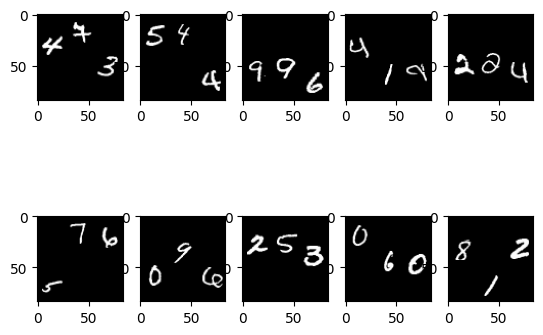

In [76]:
for i in range (10):
    plt.subplot(2,5,1+i)
    plt.imshow(images[i].reshape(84,84), cmap="gray")
plt.show()

In [77]:
image_1digit = images[0:10,:,:,0:28]
image_2digit = images[0:10,:,:,28:56]
image_3digit = images[0:10,:,:,56:]

In [78]:
image1_i =image_1digit.to(device)
pred = model_CNN(image1_i)
ans = pred.argmax(dim=1, keepdim=False)
ans

tensor([4, 5, 9, 4, 2, 5, 0, 2, 0, 8], device='cuda:0')

In [79]:
image2_i =image_2digit.to(device)
pred = model_CNN(image2_i)
ans = pred.argmax(dim=1, keepdim=False)
ans

tensor([7, 4, 9, 1, 2, 7, 9, 5, 6, 1], device='cuda:0')

In [80]:
image3_i =image_3digit.to(device)
pred = model_CNN(image3_i)
ans = pred.argmax(dim=1, keepdim=False)
ans

tensor([3, 4, 6, 9, 4, 6, 6, 3, 0, 2], device='cuda:0')

### Questions
1. What preprocessing techniques did you use? Why?
    - I used GrayScale technique, since original data is in rgb format. It reduced dimensionality of input tensor. There is no problem in doing such stuff since original picture consists only 2 main colors. Also I used Convertation of images to tensors in order to work with them.
2. What data augmentation techniques did you use?
    - Data augmentation helps to make our model more robust. I used random rotate with maximum degree 30 in order to create more complex training data. Speaking about the question why 30 degree? In my opinion with greater degree some numbers might be out of the border of the picture. Anyway validation and testing were performed on datasets without augmentation.
3. Describe the fine-tuning process and how you reached your final CNN model.
    - Well, that was kinda tricky. Fitrstly I found some working model and than started to change different parameters. Main problem was of cource time consumption on testing different configurations. By the end I found that in general models with 2 linear layers work better, from that point I started to check how performance would change with increasing number of convolution layers and number of channels in them. 
    In other words main procedure was the following I found that model with 2 convolutions and 1 linear layer works well, then I found out that such models with 2 linear layers works better. From that point I started to check number of convolutional layers and number of channels in them. More channels lead to better performance but they significantly increased training time (more than 2 times). Increasing the number of convolutional layers also made model better. There are too many possible configurations, but I decided to check only some number of them. You can check that process in tuning section. Speacking about other hyperparameters, such as lr and momentum, they haven't got so much influence on model. I tuned some of them just with using some kind of grid search. I also found that at 4th epoch accuracy is already 99% therefore I haven't much necessity to check on greater number (well ~40 sec per epoch is quite a lot of time).

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

#### Data preprocessing

In [81]:
loan_data = pd.read_csv('loan_data.csv')
loan_data

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


It seems that our dataset has no null values.

In [82]:
loan_data.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

Let's check purpuse column.

In [83]:
loan_data['purpose'].unique()

array(['debt_consolidation', 'credit_card', 'all_other',
       'home_improvement', 'small_business', 'major_purchase',
       'educational'], dtype=object)

As I know One-hot encoding isn't the best thing for DTs and RFs. Therefore I'll use ordinal encoding.

In [84]:
df_loan = ordinal_encoding(loan_data,'purpose')
df_loan

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,2.0,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,1.0,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,2.0,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,2.0,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,1.0,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,0.0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,2.0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,4.0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


Let's split data.

In [85]:
target_loan = df_loan['credit.policy']
features_loan = df_loan.iloc[:, df_loan.columns != 'credit.policy']
features_loan

,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,2.0,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1.0,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,2.0,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,2.0,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1.0,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0.0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0.0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,2.0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,4.0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


In [86]:
X_train_loan, X_test_loan, Y_train_loan, Y_test_loan = train_test_split(features_loan, target_loan, test_size = 0.2, random_state=0)

#### Usefull functions

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

def grid_search(params, classifier, X_train, X_test, Y_train, Y_test, cv=10):
    grid_search_clf = GridSearchCV(estimator=classifier(),
                               cv=cv, scoring='f1',
                               param_grid=params
                               )
    grid_search_clf.fit(X_train, Y_train)
    best_params = grid_search_clf.best_params_

    Y_pred = grid_search_clf.predict(X_test)
    return f1_score(Y_test, Y_pred), best_params

Decision Tree

In [89]:
from sklearn.tree import DecisionTreeClassifier

dt_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(1, 100)),
    'random_state':[0],
}

grid_search(dt_param_grid, DecisionTreeClassifier, X_train_loan, X_test_loan, Y_train_loan, Y_test_loan)

(0.9944823109380071,
 {'criterion': 'entropy', 'max_depth': 10, 'random_state': 0})

Decision tree with entropy and max depth 10 seems to be have the best performance according to f1 score.

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 5, 10, 15, 20, 25],
    'random_state':[0],
}

grid_search(rf_param_grid, RandomForestClassifier, X_train_loan, X_test_loan, Y_train_loan, Y_test_loan)

(0.9944823109380071,
 {'criterion': 'gini',
  'max_depth': 20,
  'n_estimators': 100,
  'random_state': 0})

#### Pictures

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)
dt.fit(X_train_loan, Y_train_loan)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)

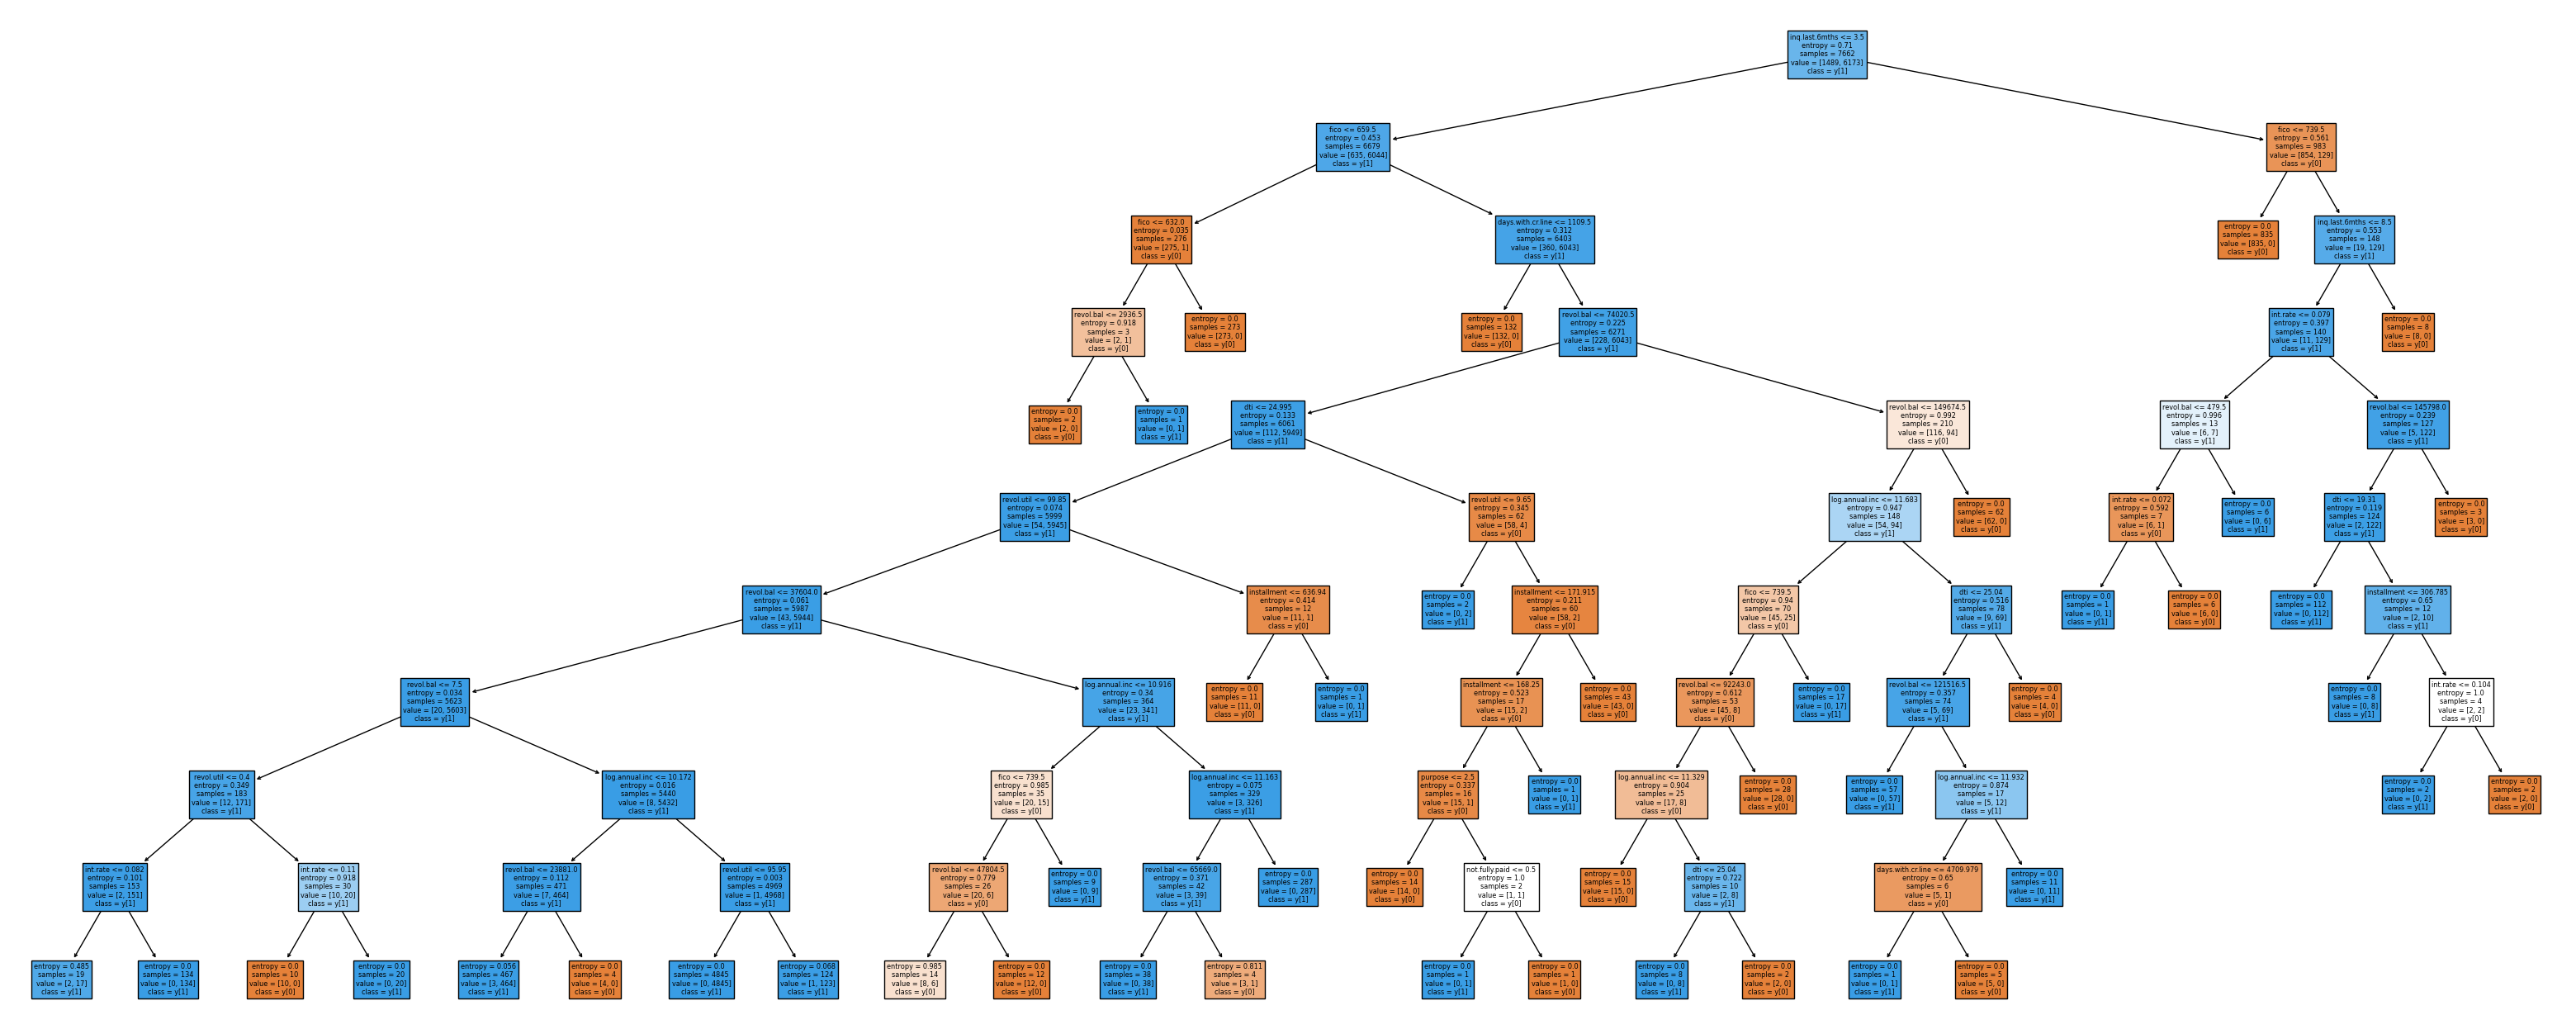

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(40,16))
plot_tree(dt, class_names = True, filled = True, feature_names = features_loan.columns,)
plt.show()

In [ ]:
rf = RandomForestClassifier(criterion='gini', max_depth=20, n_estimators=100, random_state=0)
rf.fit(X_train_loan, Y_train_loan)

RandomForestClassifier(max_depth=20, random_state=0)

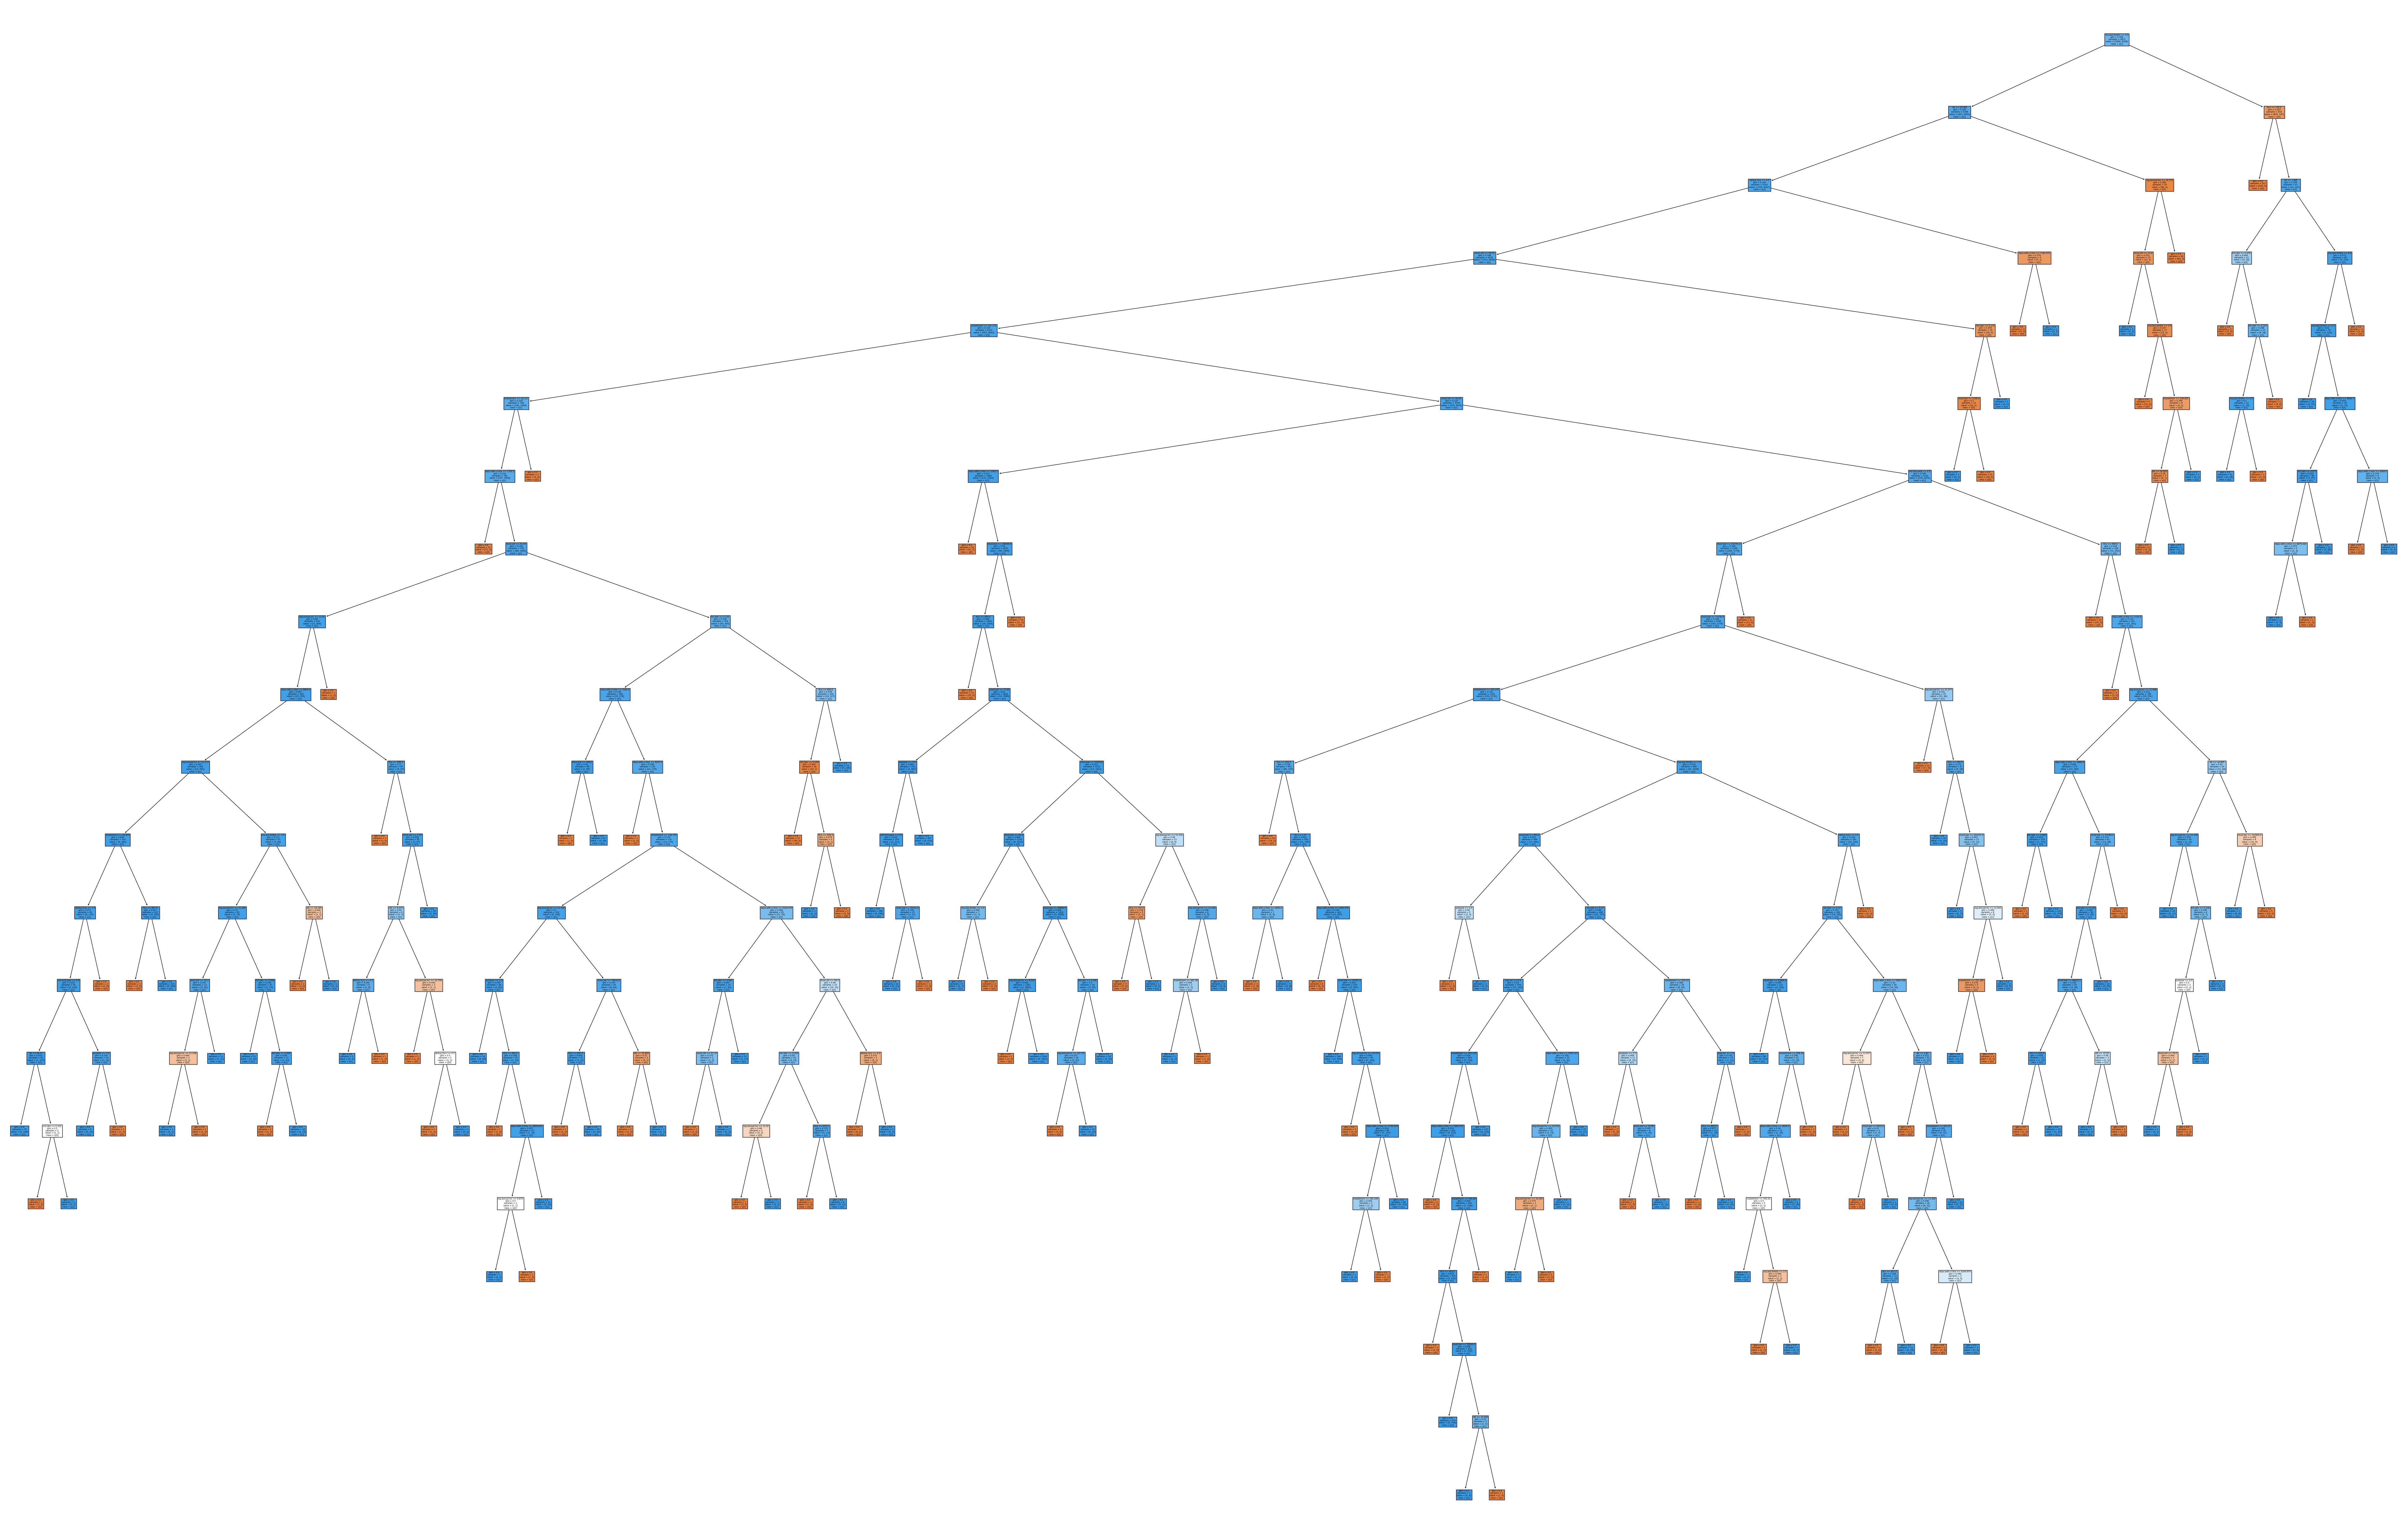

In [ ]:
plt.figure(figsize=(160,64))
plot_tree(rf.estimators_[0], class_names = True, filled = True, feature_names = features_loan.columns,)
plt.show()

Random forest with gini, 100 trees in forest and max depth 20 to have ther best berformance according to f1 score. Moreover the score is the same as in decision tree.

### Questions
1. How did the DT compare to the RF in performance? Why?
    - I expected that RF would perform better, however it hapens to be that DT and RF have same performance. DT wasn't overfited so it performed well. I suppose that it's because our data is quite good.
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - Max depth of RF is greater than DT.I suppose that since RF taken into consideration different trees it allows each of them to overfit on some part of data. When it tries to give an answer it doesn't ruin the solution (like they compensate each other), as it might happen in DT.
3. What is ensemble learning? What are its pros and cons?
    - Ensemble learning is class of ,eta-learning algorithms that combine several ML models into one predictive model in order to make a better prediction than potential prediction obtainable by single model. By combining the power of multiple models in a single model while overcoming their weaknesses, thus reducing variance and/or bias (lab 12). One of the examples is Random Forest which consists of several Decision Trees.  
    
        - `Pros:` 
        1. Ensemble learning models have better performance (more accurate prediction results). 
        2. Ensemble learning models don't underfit or overfit. 
        3. Ensemble learning models can work with linear as well as non-linear relationships in the data (f.e. by ensembling 2 models: 1 for linear and 1 for non-linear features). 
        4. Ensemble learning models are more stable and robust.
    
        - `Cons:`
        1. Ensemble learning models take more computation time and resources.
        2. It's not easy to determine which models you should include in ensemble.
        3. Tuning hyperparameters also takes more time.
        4. Ensemble learning models are more complex in general.

     
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - Boosting is converting weak learners to strong learners through Ensemble Learning (from lecture). Models are built sequentially: each model is built using information from previously built models. Boosting does not involve bootstrap sampling; instead each model is fit on a modified version of the original data set (from lab 12). In other words models one after another tries to decrease residual error. There are several ways to do it:
        - AdaBoost - for each data object we introduce some weight which is increased if recently added simple model didn't managed to classify this object correctly and decreased otherwise, therefore further models would try to correctly classify such objects.
        - Gradient boosting - the problem is converted to gradient descent. Each subsequent simple model is fitted to the opposite direction of the gradient of previous model loss function.


    - Bagging is reducing variance using an ensemble of classifiers from bootstrap samples (from lecture). Random Forest is an example of bagging. Several simple models are trained in parallel on random samples from data and later combined by some resulting process. There are several ways to produce a resulting output:
        - Take most common result from simple models
        - Summate probabilities for each class from every model and based on that determine class with greatest sum of probabilities.
        - Use some weight function on results. F.e. determine which model predict correct most the time and give it's answer greater weight (like example of smart student in the group, which most probably would answer correct on some question).

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [ ]:
# Run this funciton only 1 time in order to put all pictures in their class folders (in order to use image folder later)
def wrap_pictures_in_folders(path):
    directory = path
    for filename in os.listdir(directory):
        name = filename.split('.')[0]
        temp_path = directory+name+'/'+filename
        os.mkdir(directory+name+'/')
        os.replace(directory+ filename, temp_path)

# wrap_pictures_in_folders('./svhn/svhn/')

In [90]:
BATCH_SIZE = 100

svhn_data_transformations = transforms.Compose([
    transforms.Grayscale(),
    transforms.CenterCrop(42),
    transforms.Resize(84),
    transforms.ToTensor()
    ])

svhn_dataset = torchvision.datasets.ImageFolder(root='./svhn/svhn/', transform=svhn_data_transformations)

svhn_data_loader = DataLoader(svhn_dataset, batch_size=BATCH_SIZE, shuffle=False,  num_workers=10)

In [91]:
svhn_images, svhn_labels = next(iter(svhn_data_loader))

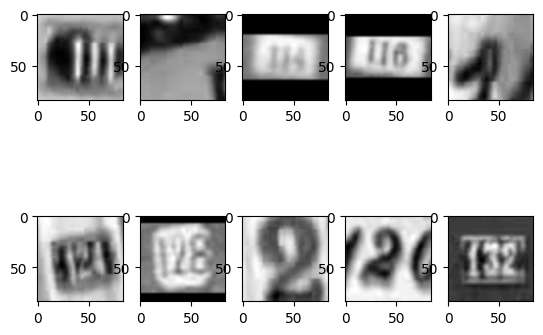

In [92]:
for i in range (10):
    plt.subplot(2,5,1+i)
    plt.imshow(svhn_images[i].reshape(84,84), cmap="gray")
plt.show()

In [93]:
test(model_CNN,device,svhn_data_loader,nn.CrossEntropyLoss())

Test set: Average loss: 9.3653, Accuracy: 24/276 (9%)



(9.365264892578125, 8.695652173913043)

### Questions
1. How did your model perform? Why is it better/worse?
    - It's not a surprise that model performed quite bad. There are several reasons for that. Firstly, pictures in dataset don't have same size. Secondly, digits on pictures can be placed in different parts. And finaly, some labels in dataset are wrong.
2. What is domain gap in the context of ML?
    - Domain gap is difference in some fetures of datasets. Unknown features might significantly influence on model performance, as we've already seen previously.
3. Suggest two ways through which the problem of domain gap can be tackled.
    - I think that increasing the dataset with data containing different features might help to reduce domain gap.
    - Applying number of augmentations techniques, additional noise attributes and etc. would also help to train model more robust. 
    - Outstanding preprocessing which would eliminate all unnecessary features of data from different domain might also help to solve that problem.